In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('data.csv')
data.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [3]:
colF4 = [col for col in data.columns if col[0:3]=='F_4']
data = data[colF4]
data.head()

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


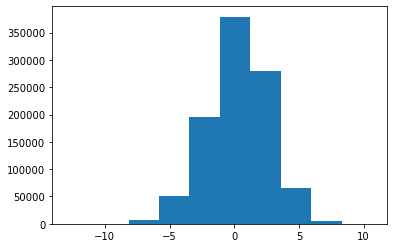

In [4]:
plt.hist(data.values[:,0]);

In [5]:
sc = MinMaxScaler(feature_range=(-1,1))
X_norm = sc.fit_transform(data.values)
means = np.nanmean(X_norm, axis=0)
means

array([ 0.12215822,  0.0081264 ,  0.52363379,  0.55646253,  0.06318847,
       -0.01269584, -0.01697574, -0.00782286,  0.57806483,  0.54337739,
        0.61090476, -0.06693178,  0.03713929, -0.02567595,  0.59464957])

(array([8.00000e+00, 3.90000e+02, 6.64500e+03, 5.00040e+04, 1.95823e+05,
        3.78967e+05, 2.79121e+05, 6.58650e+04, 4.92000e+03, 1.29000e+02]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
        -2.00000000e-01, -1.11022302e-16,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

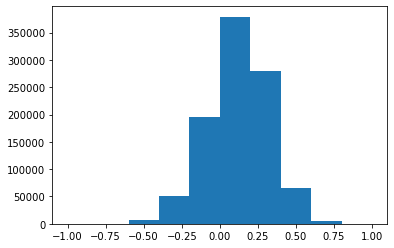

In [6]:
plt.hist(X_norm[:,0])

In [7]:
X = X_norm[np.sum(np.isnan(X_norm), axis=1)==0]
X.shape

(759268, 15)

In [103]:
class MyDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.idx = np.arange(15)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        x_noise = x.copy()
        w = np.zeros_like(x)
        
        nfill = np.random.choice([1,2,3], 1)
#         nfill = 1
        idx = np.random.choice(self.idx, nfill, replace=False)
        x_noise[idx] = -1
        w[idx] = 1.0
        
        return torch.Tensor(x_noise), torch.Tensor(x), torch.Tensor(w)

In [104]:
mydataset = MyDataset(X)

In [25]:
X[0]

array([ 0.56580515,  0.12361231,  0.51591465,  0.57154503, -0.01712219,
        0.24869956,  0.05281905, -0.01354253,  0.50090001,  0.58696563,
        0.6628569 ,  0.12974683,  0.34117027,  0.05467003,  0.77682826])

In [119]:
for _ in range(5):
    print(mydataset[0])

(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171, -1.0000,  0.0528, -0.0135,
         0.5009,  0.5870,  0.6629, -1.0000,  0.3412, -1.0000,  0.7768]), tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.2487,  0.0528, -0.0135,
         0.5009,  0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]))
(tensor([ 0.5658,  0.1236, -1.0000,  0.5715, -1.0000,  0.2487,  0.0528, -0.0135,
         0.5009, -1.0000,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.2487,  0.0528, -0.0135,
         0.5009,  0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))
(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -1.0000,  0.2487, -1.0000, -0.0135,
         0.5009,  0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.2487,  0.0528, -0.0135,
         0.5

In [121]:
class Model(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*4)
        self.bn2 = nn.BatchNorm1d(hidden_dim*4)
        self.fc3 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.bn3 = nn.BatchNorm1d(hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(self.activation(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(self.activation(self.fc3(x)))
        x = self.dropout(x)
        x = self.bn4(self.activation(self.fc4(x)))
        return nn.Tanh()(self.fc5(x))

In [75]:
def weighted_mse_loss(x, y, w):
    return torch.mean((x-y)**2*w)

In [92]:
x = torch.randn(5,15)
y = torch.randn(5,15)
w = torch.randn(5,15)

In [94]:
model = Model()
model(x)

tensor([[-0.1290, -0.2541,  0.0359, -0.3462,  0.9399, -0.7970,  0.7181,  0.2237,
          0.8190, -0.3414,  0.7266, -0.7326,  0.2264, -0.5698,  0.6713],
        [ 0.4994,  0.5547,  0.4338,  0.3145, -0.1933, -0.1578,  0.6522, -0.1275,
          0.4952,  0.6413,  0.0348, -0.1104, -0.3504, -0.0607, -0.3695],
        [ 0.0218, -0.7047, -0.2208, -0.5911,  0.1951,  0.3903, -0.9494,  0.6214,
         -0.8702,  0.5253,  0.4652,  0.7100,  0.4540,  0.4302, -0.7563],
        [ 0.3450, -0.3550,  0.1814,  0.7304, -0.6515,  0.5624, -0.5305, -0.3533,
         -0.4515,  0.1933, -0.6157,  0.3991, -0.5672, -0.3928,  0.1908],
        [-0.3912,  0.6418, -0.5097,  0.1817, -0.4818,  0.5134,  0.7521, -0.5674,
          0.4499, -0.7978, -0.4169, -0.1196,  0.0718,  0.4490,  0.0726]],
       grad_fn=<TanhBackward0>)

In [99]:
weighted_mse_loss(model(x),y,w)

tensor(0.0196, grad_fn=<MeanBackward0>)

In [78]:
def val(model, dataloader):    
    model.eval()
    with torch.no_grad():
        loss_mean = 0
        for x, y, w in dataloader:
            predict = model(x)
            loss = weighted_mse_loss(predict, y, w)
            loss_mean += loss.item() * X.shape[0]
    return loss_mean / len(dataloader.dataset)

In [80]:
def train(dataset, savename, epoches=1000, earlystop_patience=10):
    model = Model()
    
    n = len(dataset)
    n1 = int(0.9*n)
    n2 = n - n1
    train_dataset, val_dataset = random_split(dataset, [n1,n2])
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
#     print(f'starting loss={val(model, train_dataloader)}')
    
    val_loss_min = 10000.
    best_epoch = 0
    
    for epoch in range(epoches):
        
        print(f'lr={optimizer.param_groups[0]["lr"]}')
        
        if epoch - best_epoch > earlystop_patience:
            print('early stop')
            break
        
        model.train()

        loss_mean = 0
        for x, y, w in train_dataloader:
            predict = model(x)
            loss = weighted_mse_loss(predict, y, w)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * X.shape[0]
        
        loss_mean /= len(train_dataloader.dataset)
        val_loss = val(model, val_dataloader)
        print(f"{datetime.now().strftime('%H:%M:%S')}-epoch {epoch}: training loss={loss_mean}, validation loss={val_loss}")
        scheduler.step(val_loss)
        
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save({'model':model.state_dict()}, savename)

In [81]:
X.shape

(759268, 15)

In [122]:
mydataset = MyDataset(X)
train(mydataset, f'model_oneshort.pickle')

lr=0.01
22:59:09-epoch 0: training loss=3.588265749357769, validation loss=1.683422106947141
lr=0.01
23:01:34-epoch 1: training loss=1.9002042958577932, validation loss=1.609483240452705
lr=0.01
23:04:00-epoch 2: training loss=2.0103393029125978, validation loss=2.17230248818674
lr=0.01
23:06:27-epoch 3: training loss=1.969078870983274, validation loss=1.6500026250236572
lr=0.01
23:08:55-epoch 4: training loss=1.716853490888934, validation loss=1.4545335455841575
lr=0.01
23:11:22-epoch 5: training loss=1.5690887710802628, validation loss=1.320172356047301
lr=0.01
23:13:50-epoch 6: training loss=1.4474126925593593, validation loss=1.2693794069228501
lr=0.01
23:16:20-epoch 7: training loss=1.3467048210988826, validation loss=1.2082741526561502
lr=0.01
23:18:50-epoch 8: training loss=1.3077868447631495, validation loss=1.1198781594455316
lr=0.01
23:21:23-epoch 9: training loss=1.2245368814904856, validation loss=1.0296034467501964
lr=0.01
23:23:55-epoch 10: training loss=1.236274403740314

02:38:16-epoch 86: training loss=0.5688710690757965, validation loss=0.40913280013476855
lr=0.001
02:40:50-epoch 87: training loss=0.5690773651061747, validation loss=0.4082273643099077
lr=0.001
02:43:23-epoch 88: training loss=0.56806539687936, validation loss=0.40379301684700525
lr=0.001
02:45:57-epoch 89: training loss=0.5669869937720438, validation loss=0.39885503590959737
lr=0.001
02:48:30-epoch 90: training loss=0.5650886006083441, validation loss=0.4006679782914015
lr=0.001
02:51:03-epoch 91: training loss=0.5613014366568617, validation loss=0.4046243882750608
lr=0.001
02:53:44-epoch 92: training loss=0.5593071543634645, validation loss=0.39746682672576295
lr=0.001
02:56:17-epoch 93: training loss=0.5572957229239898, validation loss=0.39709140663718434
lr=0.001
02:58:50-epoch 94: training loss=0.5572780672417637, validation loss=0.38938098930770165
lr=0.001
03:01:24-epoch 95: training loss=0.5551476655173787, validation loss=0.39318626582620864
lr=0.001
03:03:57-epoch 96: traini